In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from common import get_backtest_result, get_dual_backtest_result, get_hodl_result, max_drawdown, get_cache_path, save_cache_data, load_cache_data

In [28]:
# Input
exchanges_markets = [
    {
        "binance": "BTCUSDT",
        "bitmex": "XBTUSD",
        "apollox": "BTCUSDT",
        "drift": "BTC-PERP"
    },
    {
        "binance": "ETHUSDT",
        "bitmex": "ETHUSD",
        "apollox": "ETHUSDT",
        "drift": "ETH-PERP"
    },
    {
        "binance": "SOLUSDT",
        "bitmex": "SOLUSD",
        "apollox": "SOLUSDT",
        "drift": "SOL-PERP"
    },
    {
        "binance": "XRPUSDT",
        "bitmex": "XRPUSD",
        "apollox": "XRPUSDT",
        "drift": "XRP-PERP"
    },
    {
        "binance": "BNBUSDT",
        "bitmex": "BNBUSD",
        "apollox": "BNBUSDT",
        "drift": "BNB-PERP"
    },
]

hedge_map = {
    "binance": "bitmex",
    "bitmex": "binance",
    "apollox": "binance",
    "drift": "binance"
}

funding_freq_map = {
    "BTCUSDT": 8,
    "XBTUSD": 12,
    "BTCUSDT": 8,
    "BTC-PERP": 1,
    "ETHUSDT": 8,
    "ETHUSD": 8,
    "ETHUSDT": 8,
    "ETH-PERP": 1,
    "SOLUSDT": 8,
    "SOLUSD": 8,
    "SOLUSDT": 8,
    "SOL-PERP": 1,
    "XRPUSDT": 8,
    "XRPUSD": 8,
    "XRPUSDT": 8,
    "XRP-PERP": 1,
    "BNBUSDT": 8,
    "BNBUSD": 8,
    "BNBUSDT": 8,
    "BNB-PERP": 1,
}

In [29]:
# Compute all combinations of funding rate PNL

# Initial variables
min_time = datetime.fromisoformat('2023-05-01').timestamp()
max_time = datetime.fromisoformat('2023-12-31').timestamp()

data_df_map = {}
results = {}

leverages = [1, 3, 5, 7]

# Read data from file
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        data_df = load_cache_data(exchange, market)
        
        if exchange not in data_df_map:
            data_df_map[exchange] = {}
        data_df_map[exchange][market] = data_df

# calculate min max time
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        data_df = data_df_map[exchange][market]
        min_time = max(min_time, data_df["timestamp"].min())
        max_time = min(max_time, data_df["timestamp"].max())

# Calculate funding rate backtest result
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        short_df = data_df_map[exchange][market]
        short_df['datetime'] = short_df['datetime'].apply(lambda x: pd.to_datetime(x))
        short_df = short_df[
            (short_df["timestamp"] >= min_time) & (short_df["timestamp"] <= max_time)
        ]
        short_df = short_df.sort_values(by='datetime', ascending=True)
        short_df = short_df.reset_index(drop=True)
        
        long_exchange = hedge_map[exchange]
        long_market = exchanges_market[long_exchange]
        long_df = data_df_map[long_exchange][long_market]
        long_df['datetime'] = long_df['datetime'].apply(lambda x: pd.to_datetime(x))
        long_df = long_df[
            (long_df["timestamp"] >= min_time) & (long_df["timestamp"] <= max_time)
        ]
        long_df = long_df.sort_values(by='datetime', ascending=True)
        long_df = long_df.reset_index(drop=True)

        if exchange not in results:
            results[exchange] = {}
        if market not in results[exchange]:
            results[exchange][market] = {}

        for leverage in leverages:
            if leverage == 1:
                result_df = get_backtest_result(short_df, leverage)
            else:
                (result_df, _, _) = get_dual_backtest_result(long_df, short_df, funding_freq_map[long_market], funding_freq_map[market], leverage)
            results[exchange][market][leverage] = result_df

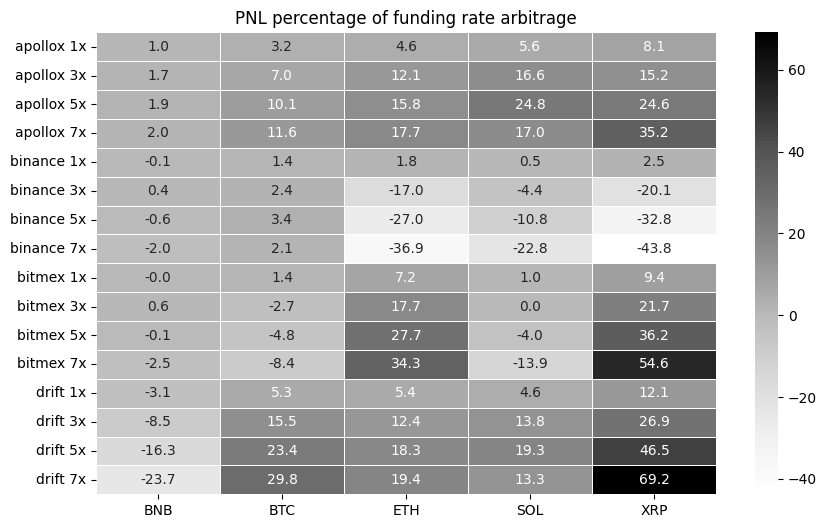

In [30]:
import seaborn as sns

# Example PNL data (replace with your actual data)
data = {
    'market': [],
    'key': [],
    'pnl': []
}

for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        market_name = market.replace("USDT", "").replace("-PERP", "").replace("USD", "")
        market_name = 'BTC' if market_name == "XBT" else market_name
        for leverage in leverages:
            key = f"{exchange} {leverage}x"
            value = results[exchange][market][leverage]['final_pnl'].iloc[-1] * 100
            data["market"].append(market_name)
            data["key"].append(key)
            data['pnl'].append(value)
            
df = pd.DataFrame(data)

# Pivot the DataFrame to prepare for heatmap
heatmap_data = df.pivot_table(index='key', columns='market', values='pnl')

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 6))
# sns.heatmap(heatmap_data, annot=True, cmap="Greys", fmt=".1f", linewidths=0.5)
heatmap = sns.heatmap(heatmap_data, annot=True, cmap="Greys", fmt=".1f", linewidths=0.5)

# Adding labels and title
heatmap.set_xlabel('')
heatmap.set_ylabel('')

plt.title('PNL percentage of funding rate arbitrage')

plt.savefig(f'./images/pnl_heatmap.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
